In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
from scipy.stats import kruskal
import scikit_posthocs as sp
from matplotlib.colors import ListedColormap

In [2]:
path= Path(f'../../data/cluster_results')

In [3]:
def read_csv(f):
    df = pd.read_csv(f)
#     df['std'] = pd.read_csv(f).std().iloc[0] #remove this line to remove std from table

    df['experiment'] = f.parent.parent.parent.name
    df['function'] = f.parent.parent.name
    name = f.parent.name
    #print(name)
    df['freq'] = name[4:].split('n')[0]
    #print(df['freq'])
    #df['method'] = f.name.split('_')[0]
    name = f.name.split('_')[0]
    if name != 'noNNReval': name += '_'+f.name.split('_')[1]
    df['method'] = name
    df['nn_p']=name[14:].split('n')[0] 

    return df

measure_name=['mof','sr','arr','nfe','nn_time']
index_measure=0

In [4]:
m = measure_name[index_measure]

In [5]:
def get_data(m, freq):
    files = list(f for f in path.glob(f'exp*/*/freq{freq}nn_w5nn_p3nn_s3nn_tw5nn_bs4nn_epoch3/*{m}.csv') if 'NNnorm' in f.name) #path.glob(f'exp*/*/freq1*nn_s*nn_tw*bs*/*{m}.csv')
    files += [f for f in path.glob(f'exp*/*/freq{freq}*nn_p3nn_s2nn_tw5*bs4*/*{m}.csv') if 'noNN' in f.name] #f'exp*/*/*nn_p3/*{m}.csv'  , 
    df = pd.concat([read_csv(f) for f in files])    

    unique_exp = df.experiment.unique()
    unique_fun = df.function.unique()
    labels = ['noNNReval', 'NNnorm_Worst', 'NNnorm_Random']
    pcs = {}

    for exp in unique_exp:
        pcs[exp] = {}
        for fun in unique_fun:
            temp_df = df[(df.experiment==exp) & (df.function==fun)]
            noNNReval = temp_df.query("method == 'noNNReval'").mof
            NNnorm_Random = temp_df.query("method == 'NNnorm_Random'").mof
            NNnorm_Worst = temp_df.query("method == 'NNnorm_Worst'").mof
            x=np.array([noNNReval, NNnorm_Worst,NNnorm_Random])
            stat, p = kruskal(noNNReval,NNnorm_Worst,NNnorm_Random)
            pc = sp.posthoc_conover(x, p_adjust='holm', val_col='values', group_col='groups')
            pc.columns = ['noNN','NNW','NNR'] # labels
            pc.index = ['noNN','NNW','NNR'] # labels
            pcs[exp][fun] = pc
            
    return pcs

In [6]:
def plot_heatmap(pc):
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    ax,cbar = sp.sign_plot(pc, **heatmap_args)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_yticklabels(labels, rotation='horizontal')
    plt.tight_layout()
#exp_pc.keys()
#pcs.keys()

NameError: name 'pcs' is not defined

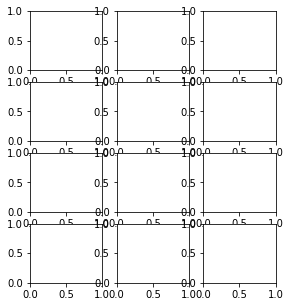

In [7]:
fig,all_axs = plt.subplots(4, 3, figsize=(4.4,5))#10,14
for i,exp in enumerate(['exp1','exp2','exp3','exp4']):
    exp_pc = pcs[exp]
    axs = all_axs[i]
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True,
                    'cbar_ax_bbox': [1.0, 0.6, 0.04, 0.3]}
    sp.sign_plot(exp_pc['sphere'], ax=axs[0], **heatmap_args)
    sp.sign_plot(exp_pc['rosenbrock'], ax=axs[1], **heatmap_args)
    axs[1].set_yticklabels([])
    _,cbar = sp.sign_plot(exp_pc['rastrigin'], ax=axs[2], **heatmap_args)
    axs[2].set_yticklabels([])
    if i==0:
        for ax,t in zip(axs,['sphere','rosenbrock','rastrigin']): ax.set_title(t.title())
    for ax in axs:
        if i<3: ax.set_xticklabels([])
    
plt.tight_layout()
plt.savefig(path/'kruskal4.eps', format='eps', dpi=1000)

In [148]:
def plot_one(m, freq, legend=False):
    pcs = get_data(m, freq)
    fig,all_axs = plt.subplots(3, 4, figsize=(5,4))#, sharex=True, sharey=True)#10,14

    for i,exp in enumerate(['exp1','exp2','exp3','exp4']):
        exp_pc = pcs[exp]
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True,
                        'cbar_ax_bbox': [1.0, 0.6, 0.04, 0.3]}
        sp.sign_plot(exp_pc['sphere'], ax=all_axs[0][i], **heatmap_args)
        sp.sign_plot(exp_pc['rosenbrock'], ax=all_axs[1][i], **heatmap_args)
        _,cbar = sp.sign_plot(exp_pc['rastrigin'], ax=all_axs[2][i], **heatmap_args)
        if legend==False: cbar.remove()

    for i,ax in enumerate(all_axs[0]): ax.set_title(f'exp{i+1}')    
    for ax in all_axs[:-1].flatten(): ax.set_xticks([])
    for axs in all_axs:
        for ax in axs[1:]: ax.set_yticks([])
        
    for ax,t in zip([o[0] for o in all_axs],['Sphere','Rosenbrock','Rastrigin']): ax.set_ylabel(t)
    plt.tight_layout()
    return fig,all_axs

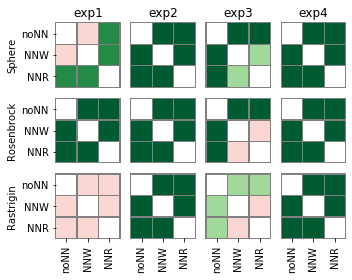

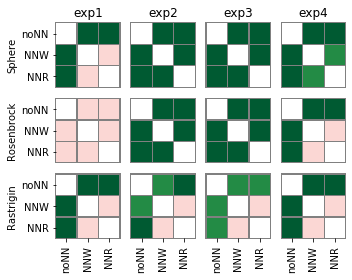

/Users/maryam/anaconda3/envs/denn/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


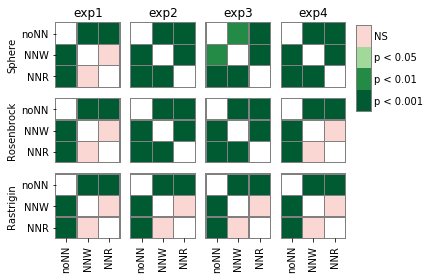

In [149]:
for freq,legend in zip([0.5,1,4],[False,False,True]):
    fig,ax = plot_one(m,freq,legend)
    plt.show()
    freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq
    fig.savefig(path/f'kruskal{freq_lbl}.eps', format='eps', dpi=1000, bbox_inches='tight')

# ---

In [29]:
cbar

In [231]:
ax,cbar = sp.sign_plot(kpc, ax=axs[0], **heatmap_args)
ax,cbar = sp.sign_plot(pc, ax=axs[1], **heatmap_args)
ax.set_xticklabels(labels, rotation='vertical')
ax.set_yticklabels(labels, rotation='horizontal')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

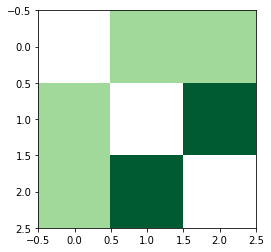

In [168]:
hm = pc.copy()
hm[(pc <= 0.001) & (pc >= 0)] = 1
hm[(pc <= 0.01) & (pc > 0.001)] = 2
hm[(pc <= 0.05) & (pc > 0.01)] = 3
hm[(pc > 0.05)] = 0
np.fill_diagonal(hm.values, -1)
cmap = ['1', '#fbd7d4', '#005a32', '#238b45', '#a1d99b']
ax.imshow(hm, cmap=ListedColormap(cmap))
cbar = ColorbarBase(cbar_ax, cmap=ListedColormap(cmap[2:] + [cmap[1]]),
                    boundaries=[0, 1, 2, 3, 4])
cbar.set_ticks(np.linspace(0.5, 3.5, 4))
cbar.set_ticklabels(['p < 0.001', 'p < 0.01', 'p < 0.05', 'NS'])

cbar.outline.set_linewidth(1)
cbar.outline.set_edgecolor('0.5')
cbar.ax.tick_params(size=0)

In [172]:
sp.sign_plot??

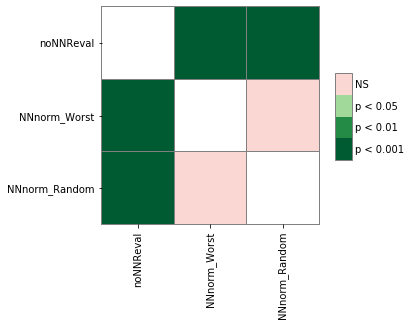

In [150]:
ax,cbar = sp.sign_plot(pc, **heatmap_args)
cmap = ['1', '#fbd7d4', '#005a32', '#238b45', '#a1d99b']

# ---